# Example-15:  Differentiable fixed point

In [1]:
# In this example fixed point parametric derivative is illustrated

In [2]:
# Import

import numpy

import jax
from jax import jit
from jax import vmap

# Test symplectic mapping and corresponding inverse

from tohubohu.util import forward2D
from tohubohu.util import inverse2D

# REM factory

from tohubohu import rem

# Fixed point

from tohubohu import iterate
from tohubohu import prime
from tohubohu import unique
from tohubohu import chain
from tohubohu import monodromy
from tohubohu import combine
from tohubohu import classify
from tohubohu import manifold

# Iteration

from tohubohu import nest
from tohubohu import nest_list

# Plotting

from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis')
cmap.set_bad(color='lightgray')

In [3]:
# Set data type

jax.config.update("jax_enable_x64", True)

In [4]:
# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

In [5]:
# Set initial grid

n = 1001

qs = jax.numpy.linspace(-0.75, 1.00, n)
ps = jax.numpy.linspace(-0.75, 1.00, n)
xs = jax.numpy.stack(jax.numpy.meshgrid(qs, ps, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1)
xs.shape

(1002001, 2)

In [6]:
# Set indicator

fn = jit(rem(2**12, forward2D, inverse2D))

x = jax.numpy.array([0.00, 0.00])
k = jax.numpy.array([0.46, 0.00])

fn(x, k) ;

In [7]:
%%time

# Map indicator over a grid

out = jit(vmap(fn, (0, None)))(xs, k).block_until_ready()

CPU times: user 3min 9s, sys: 1.93 s, total: 3min 11s
Wall time: 35.5 s


In [8]:
# Winsorize data

data = numpy.log10(1.0E-16 + numpy.array(out.tolist()))
data[data < -15.0] = -15.0
data[data > 0.0] = 0.0
data = data.reshape(n, n)

In [9]:
# Set symmetry lines

def diagonal(q, k):
    w, s = k
    return q

def force(q, k):
    w, s = k
    return 0.5*(w*q + q**2 + s*q**3)

In [10]:
# Set initial points for fixed point computation (for each line)

size = 256
qs = jax.numpy.linspace(-1.0, 1.0, size)
xs = jax.numpy.vstack([jax.numpy.stack([qs, diagonal(qs, k)]).T, jax.numpy.stack([qs, force(qs, k)]).T])

In [11]:
# Compute fixed points

limit = 32
order = 5
 
solver = jit(vmap(iterate(limit, forward2D, order=order), (0, None)))
points = solver(xs, k)
points = points[~jax.numpy.any(jax.numpy.isnan(points), -1)]

# Prime period

mask = jit(vmap(prime(forward2D, order=order, rtol=1.0E-12, atol=1.0E-12), (0, None)))(points, k)
points = points[mask]

# Unique

mask = unique(order, forward2D, points, k, tol=1.0E-12)
points = points[mask]

# Chains

chains = jax.numpy.vstack(jit(vmap(chain(order, forward2D), (0, None)))(points, k))

In [12]:
# Classify and set hyperbolic point

ms = jit(vmap(monodromy(order, forward2D), (0, None)))(points, k)
es, vs = vmap(jax.numpy.linalg.eig)(ms)

mask = classify(es)
ph = points[~mask].squeeze()

print(ph)
print(jax.numpy.linalg.eigvals(monodromy(order, forward2D)(ph, k)))

[0.59537648 0.31417317]
[0.61071476+0.j 1.63742564+0.j]


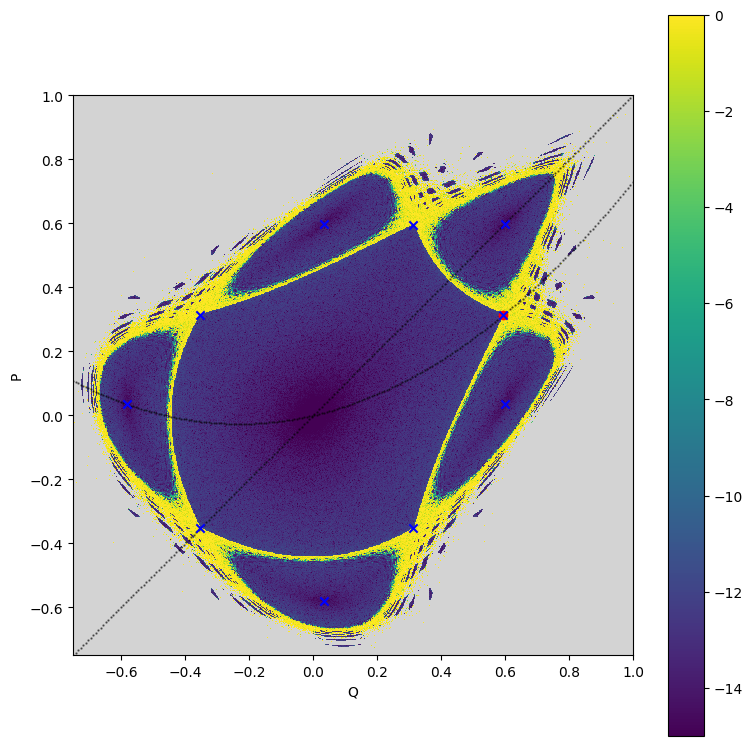

In [13]:
# Plot

plt.figure(figsize=(8, 8))
plt.scatter(*xs.T, color='black', s=0.5, alpha=0.5)
plt.scatter(*ph, color='red', marker='o')
plt.scatter(*chains.T, color='blue', marker='x')
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1.0, -0.75, 1.0))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

In [14]:
# Fixed point derivative

solver = iterate(1, forward2D, order=order)

print(ph)
print(solver(ph, k))
print(jax.jacfwd(solver, -1)(ph, k))

[0.59537648 0.31417317]
[0.59537648 0.31417317]
[[-2.0661918   0.12217981]
 [-1.40769788  0.02913025]]


In [15]:
# Monodromy matrix trace derivative

def trace(k):
    return jax.numpy.linalg.trace(monodromy(order, forward2D)(ph, k))

print(trace(k))
print(jax.jacfwd(trace)(k))

2.2481403943386873
[-1.08958069 -1.0408802 ]
